In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, h5py
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = str(len(os.sched_getaffinity(0)))
import healpy as hp

from scipy.signal import savgol_filter
from tqdm import tqdm

from deepsphere.healpy_layers import HealpySmoothing
from msfm.utils import tfrecords, files, parameters, scales, power_spectra, cross_statistics
from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils.input_output import read_yaml

from msi.utils import preprocessing, plotting, input_output

tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)

24-05-27 03:29:41   imports.py INF   Setting up healpy to run on 32 CPUs 
24-05-27 03:29:41   imports.py INF   Setting up healpy to run on 32 CPUs 
24-05-27 03:29:42   imports.py INF   Setting up healpy to run on 32 CPUs 


In [3]:
[np.sqrt(3)*3, 5]

[5.196152422706632, 5]

In [4]:
conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v8/linear_bias_no_smoothing.yaml"
conf = files.load_config(conf)

n_side = conf["analysis"]["n_side"]
n_pix = hp.nside2npix(n_side)
n_z = 8
l_min_global = 30
l_max_global = 3 * n_side - 1

fwhm = [22.1, 15.1, 11.2, 9.4] + [65.1, 44.5, 34.1, 28.5]

# base_fwhm = 9.4
# fwhm = [
#     np.sqrt(6)*base_fwhm, 
#     np.sqrt(3)*base_fwhm, 
#     np.sqrt(2)*base_fwhm, 
#     base_fwhm, 
#     np.sqrt(48)*base_fwhm, 
#     np.sqrt(23)*base_fwhm, 
#     np.sqrt(14)*base_fwhm, 
#     np.sqrt(10)*base_fwhm, 
# ]

l_max_naives = list(scales.angle_to_ell(np.array(fwhm), arcmin=True).astype(int))

# loop through the maps

In [5]:
tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v8/linear_bias_no_smoothing/tfrecords/fiducial/DESy3_fiducial_dmb_????.tfrecord"

In [6]:
fidu_pipe = FiducialPipeline(
    conf=conf,
    params=[],
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    # apply_norm=False,
    apply_norm=True,
    shape_noise_scale=1.0,
    poisson_noise_scale=1.0,
)

data_vec_pix = fidu_pipe.data_vec_pix

fidu_dset = fidu_pipe.get_dset(
    tfr_pattern=tfr_pattern,
    local_batch_size=1,
    noise_indices=10,
    n_readers=1,
    examples_shuffle_buffer=None,
    n_prefetch=2,
    is_eval=True,
)

24-05-27 03:29:46     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
24-05-27 03:29:46     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
24-05-27 03:29:47 fiducial_pip WAR   Evaluation mode is activated: the random seed is fixed, the shuffle arguments ignored, and the dataset is not repeated 
24-05-27 03:29:47 fiducial_pip INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-05-27 03:29:47 fiducial_pip INF   drop_remainder is not set, using drop_remainder = False 
24-05-27 03:29:47 fiducial_pip INF   Including noise_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
24-05-27 03:29:47 fiducial_pip INF   Interleaving with n_readers = 1 
24-05-27 03:29:47 fiducial_pip INF   Batching into 1 elements locally with drop_remainder = False 
24-05-27 03:29:48 fiducial_pip WAR   Tracing _augmentations 
Pleas

# smoothing layer

In [7]:
mask_dict = files.get_tomo_dv_masks(conf)
mask = tf.concat([mask_dict["metacal"], mask_dict["maglim"]], axis=1)    
mask = mask.numpy()

smoothing_kwargs = {
    "nside": n_side,
    "indices": data_vec_pix,
    "nest": True,
    # "mask": mask,
    "fwhm": fwhm,
    "arcmin": True,
    "n_sigma_support": 3,
    # "data_path": ".",
}

smoothing_layer = HealpySmoothing(**smoothing_kwargs)

actual_fwhm = smoothing_layer.fwhm_arcmin * np.sqrt(smoothing_layer.per_channel_repetitions)

24-05-27 03:29:50     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
Using the per channel smoothing repetitions [ 6  3  2  1 48 23 14 10]
Using the per channel smoothing scales sigma = [ 9.78  6.91  5.65  3.99 27.66 19.14 14.94 12.62] arcmin, fwhm = [23.03 16.28 13.29  9.4  65.13 45.08 35.17 29.73] arcmin
Creating tree for 464896 pixels and radius n_sigma_support * sigma = 11.98 arcmin
The maximal number of neighbors within that radius is 13


querying the tree: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


Successfully created the sparse kernel tensor


In [8]:
n_examples = 10

raw_cls = np.zeros((n_examples, l_max_global, n_z))
smooth_cls = np.zeros((n_examples, l_max_global, n_z))
for i, (dv, index) in tqdm(enumerate(fidu_dset.take(n_examples)), total=n_examples):
    smooth_dv = smoothing_layer(dv)
    
    for j in range(n_z):        
        # raw
        raw_map = np.zeros(n_pix)
        raw_map[data_vec_pix] = dv[...,j]
        raw_map = hp.reorder(raw_map, n2r=True)
        raw_cls[i,:,j] = hp.anafast(raw_map, lmax=l_max_global-1)

        # smoothed
        smooth_map = np.zeros(n_pix)
        smooth_map[data_vec_pix] = smooth_dv[...,j]
        smooth_map = hp.reorder(smooth_map, n2r=True)
        smooth_cls[i,:,j] = hp.anafast(smooth_map, lmax=l_max_global-1)

raw_cls = np.mean(raw_cls, axis=0)
smooth_cls = np.mean(smooth_cls, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

Successfully built the smoothing layer


100%|██████████| 10/10 [01:04<00:00,  6.45s/it]


# percentage criterion

[0.63374438 0.43044257 0.33473713 0.52790543 1.47078448 0.8278368
 0.6266455  0.7040794 ]


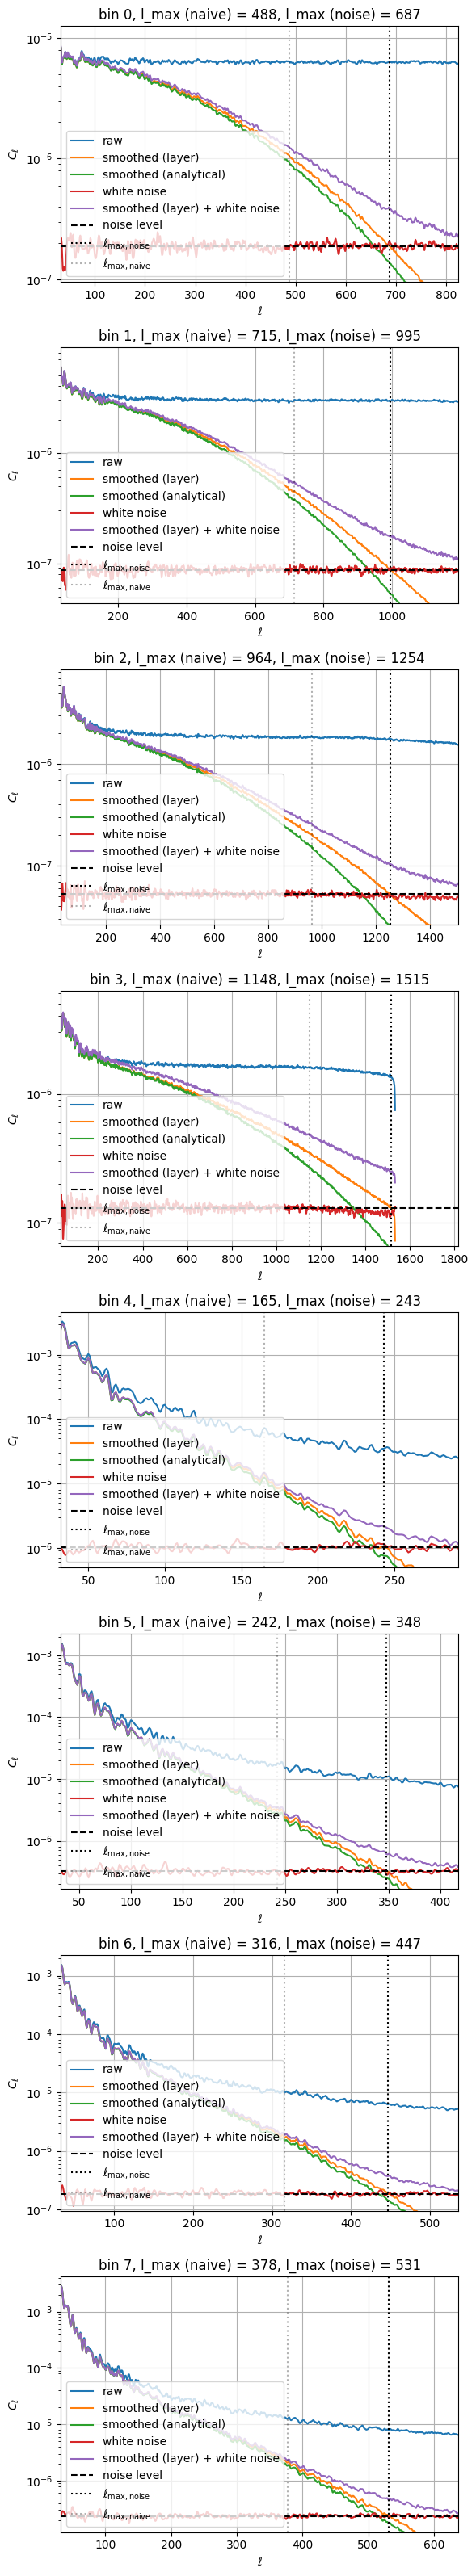

In [9]:
# the noise level is determined to be equal to the value for which the Cl are suppressed this much
# threshold = 0.1
threshold = 0.03
# threshold = 0.01
l = np.arange(l_max_global)

fig, ax = plt.subplots(figsize=(6, 4*n_z), nrows=n_z, sharex=False, sharey=False)

sigmas_percent = []
noises_percent = []
for i in range(n_z):
    l_max_naive = l_max_naives[i]
    
    current_raw_cls = raw_cls[:,i]
    current_smooth_cls = smooth_cls[:,i]
    # low_pass_fac_cls = scales.gaussian_low_pass_factor_alm(l, theta_fwhm=fwhm[i])**2
    low_pass_fac_cls = scales.gaussian_low_pass_factor_alm(l, theta_fwhm=actual_fwhm[i])**2
    current_analytical_cls = raw_cls[:,i]*low_pass_fac_cls
            
    try:
        l_max_noise = l[(current_smooth_cls/current_raw_cls) < threshold][0]
    except IndexError:
        l_max_noise = l_max_global - 20
        
    # generate white noise
    noise_level_cl = current_smooth_cls[l_max_noise]
    sigma = np.sqrt(noise_level_cl / hp.nside2pixarea(n_side))
    # rough correction factor since we're only considering the partial sky, see white_noise_toy.ipynb
    sigma *= np.sqrt(8.5)
    sigmas_percent.append(sigma)

    white_noise_map = np.zeros(n_pix)
    white_noise_map[data_vec_pix] = mask[:,i] * np.random.normal(loc=0, scale=sigma, size=len(data_vec_pix))
    white_noise_map = hp.reorder(white_noise_map, n2r=True)
    white_noise_cls = hp.anafast(white_noise_map, lmax=l_max_global-1)
    
    ax[i].plot(raw_cls[:,i], label="raw")
    ax[i].plot(smooth_cls[:,i], label="smoothed (layer)")
    ax[i].plot(current_analytical_cls, label="smoothed (analytical)")
    ax[i].plot(white_noise_cls, label="white noise")
    ax[i].plot(smooth_cls[:,i] + white_noise_cls, label="smoothed (layer) + white noise")

    ax[i].axhline(noise_level_cl, color="k", linestyle="--", label="noise level")
    ax[i].axvline(l_max_noise, color="k", linestyle=":", label=r"$\ell_\mathrm{max,noise}$")
    ax[i].axvline(l_max_naive, color="k", linestyle=":", label=r"$\ell_\mathrm{max,naive}$", alpha=0.3)

    ax[i].set(
        xscale="linear", 
        yscale="log", 
        title=f"bin {i}, l_max (naive) = {l_max_naive}, l_max (noise) = {l_max_noise}", 
        xlabel=r"$\ell$", 
        ylabel=r"$C_\ell$", 
        xlim=(32, l_max_noise*1.2),
        ylim=(0.5 * smooth_cls[32:l_max_noise,i].min(), 1.5 * smooth_cls[32:l_max_noise,i].max()),
    )
    ax[i].grid(True)
    ax[i].legend(loc="lower left")
    
fig.tight_layout()

sigmas_percent = np.array(sigmas_percent)
print(sigmas_percent)